### Project setup

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import pickle

from sklearn.preprocessing import StandardScaler
%matplotlib inline


In [2]:
image = mpimg.imread('test_images/cutout1.jpg')

In [3]:
cars = pickle.load(open('data/car_imgs.p', 'rb'))
notcars = pickle.load(open('data/non_car_imgs.p', 'rb'))

### Scikit image HOG

In [4]:
from skimage.feature import hog

def convert_colorspace(img, color_space='RGB'):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb' or color_space == 'YCC':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        elif color_space == 'GRAY':
            feature_image = cv2.cvtColor(img, cv2.COLOR_)
    else: feature_image = np.copy(img)             
    return feature_image

    
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualise=True, feature_vector=False, transform_sqrt=False,
                          )
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualise=False, feature_vector=feature_vec, transform_sqrt=False,
                          )
        return features

    

In [5]:

def plot_hog_features(img_list, title='Car:', color_space='RGB', orient=9, pix_per_cell=8, cell_per_block=2):
    # Generate a random index to look at a car image
    ind = np.random.randint(0, len(cars))
    # Read in the image
    image = img_list[ind]
    color_img = convert_colorspace(image, color_space)
    
    # Plot the examples
    fig = plt.figure()
    plt.subplot(1, 4, 1)
    plt.imshow(image)
    plt.title(title+': '+color_space)
    
    for i in range(3):
        # Call our function with vis=True to see an image output
        features, hog_image = get_hog_features(color_img[:,:,i], orient, 
                                pix_per_cell, cell_per_block, 
                                vis=True, feature_vec=False)

        plt.subplot(1, 4, 2+i)
        plt.imshow(hog_image, cmap='gray')
        plt.title(color_space[i])
        
    fig.savefig('output_images/gradient_visualization_'+color_space+'.png')



/Users/andrewshaw/miniconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


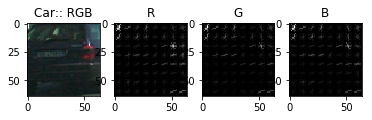

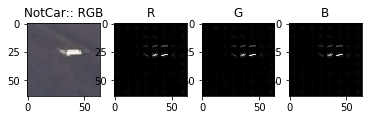

In [6]:
plot_hog_features(cars)
plot_hog_features(notcars, 'NotCar:')

/Users/andrewshaw/miniconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


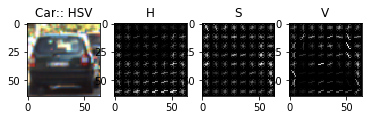

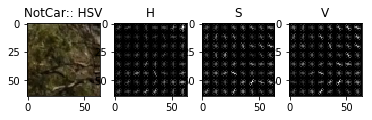

In [7]:
plot_hog_features(cars, color_space='HSV')
plot_hog_features(notcars, title='NotCar:', color_space='HSV')

/Users/andrewshaw/miniconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


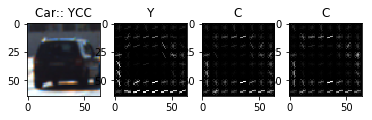

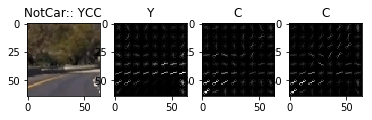

In [8]:
plot_hog_features(cars, color_space='YCC')
plot_hog_features(notcars, title='NotCar:', color_space='YCC')

### HOG Classify

In [9]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split


# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_hog_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for img in imgs:
        feature_image = convert_colorspace(img, 'RGB')
        
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

# Reduce the sample size because HOG features are slow to compute
# The quiz evaluator times out after 13s of CPU time
# sample_size = 500
# cars = cars[0:sample_size]
# notcars = notcars[0:sample_size]

def load_hog_features(colorspace, orient, pix_per_cell, cell_per_block, hog_channel):
    t=time.time()
    
    picklefile = colorspace+str(orient)+'-'+str(pix_per_cell)+'-'+str(cell_per_block)+'-'+str(hog_channel)
    car_features_file = 'data/'+picklefile+'-car_features.p'
    notcar_features_file = 'data/'+picklefile+'-noncar_features.p'
    try:
        car_features = pickle.load(open(car_features_file, 'rb'))
        notcar_features = pickle.load(open(notcar_features_file, 'rb'))
        t2 = time.time()
        print(round(t2-t, 2), 'Seconds to load HOG features from save...')
    except FileNotFoundError as e:
        car_features = extract_hog_features(cars, cspace=colorspace, orient=orient, 
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                hog_channel=hog_channel)
        notcar_features = extract_hog_features(notcars, cspace=colorspace, orient=orient, 
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                hog_channel=hog_channel)
        
        pickle.dump(car_features, open(car_features_file, "wb"))
        pickle.dump(notcar_features, open(notcar_features_file, "wb"))

        t2 = time.time()
        print(round(t2-t, 2), 'Seconds to extract HOG features...')
    return car_features, notcar_features

def predict(colorspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    car_features, notcar_features = load_hog_features(colorspace, orient, pix_per_cell, cell_per_block, hog_channel)
    t=time.time()
    
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block', 'and', colorspace, 'colorspace')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    print('---------------------------------------------------------')

/Users/andrewshaw/miniconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [10]:
for channel in [0, 1, 2, 'ALL']:
    predict(colorspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=channel)

0.34 Seconds to load HOG features from save...
Using: 9 orientations 8 pixels per cell and 2 cells per block and RGB colorspace
Feature vector length: 1764
10.18 Seconds to train SVC...
Test Accuracy of SVC =  0.9336
---------------------------------------------------------
0.25 Seconds to load HOG features from save...
Using: 9 orientations 8 pixels per cell and 2 cells per block and RGB colorspace
Feature vector length: 1764
7.87 Seconds to train SVC...
Test Accuracy of SVC =  0.9476
---------------------------------------------------------
0.24 Seconds to load HOG features from save...
Using: 9 orientations 8 pixels per cell and 2 cells per block and RGB colorspace
Feature vector length: 1764
7.78 Seconds to train SVC...
Test Accuracy of SVC =  0.9513
---------------------------------------------------------
0.56 Seconds to load HOG features from save...
Using: 9 orientations 8 pixels per cell and 2 cells per block and RGB colorspace
Feature vector length: 5292
22.41 Seconds to trai

In [11]:
for colorspace in ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCC']:
    predict(colorspace=colorspace, orient=9, pix_per_cell=8, cell_per_block=2, hog_channel='ALL')

0.51 Seconds to load HOG features from save...
Using: 9 orientations 8 pixels per cell and 2 cells per block and RGB colorspace
Feature vector length: 5292
20.32 Seconds to train SVC...
Test Accuracy of SVC =  0.9668
---------------------------------------------------------
0.64 Seconds to load HOG features from save...
Using: 9 orientations 8 pixels per cell and 2 cells per block and HSV colorspace
Feature vector length: 5292
20.38 Seconds to train SVC...
Test Accuracy of SVC =  0.9662
---------------------------------------------------------
0.64 Seconds to load HOG features from save...
Using: 9 orientations 8 pixels per cell and 2 cells per block and LUV colorspace
Feature vector length: 5292
20.3 Seconds to train SVC...
Test Accuracy of SVC =  0.9671
---------------------------------------------------------
0.63 Seconds to load HOG features from save...
Using: 9 orientations 8 pixels per cell and 2 cells per block and HLS colorspace
Feature vector length: 5292
19.78 Seconds to tra

In [12]:
for orientation in [6, 8, 10]:
    predict(colorspace='RGB', orient=orientation, pix_per_cell=8, cell_per_block=2, hog_channel='ALL')

/Users/andrewshaw/miniconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


57.17 Seconds to extract HOG features...
Using: 6 orientations 8 pixels per cell and 2 cells per block and RGB colorspace
Feature vector length: 3528
14.85 Seconds to train SVC...
Test Accuracy of SVC =  0.9586
---------------------------------------------------------
54.04 Seconds to extract HOG features...
Using: 8 orientations 8 pixels per cell and 2 cells per block and RGB colorspace
Feature vector length: 4704
18.09 Seconds to train SVC...
Test Accuracy of SVC =  0.9696
---------------------------------------------------------
58.84 Seconds to extract HOG features...
Using: 10 orientations 8 pixels per cell and 2 cells per block and RGB colorspace
Feature vector length: 5880
24.43 Seconds to train SVC...
Test Accuracy of SVC =  0.9659
---------------------------------------------------------


In [13]:
for (ppc, cpb) in ([(4, 2), (8, 2), (16, 2), (4, 1), (8, 1), (16, 1), (8, 4), (16, 4)]):
    predict(colorspace='RGB', orient=9, pix_per_cell=ppc, cell_per_block=cpb, hog_channel='ALL')

4.79 Seconds to load HOG features from save...
Using: 9 orientations 4 pixels per cell and 2 cells per block and RGB colorspace
Feature vector length: 24300
49.12 Seconds to train SVC...
Test Accuracy of SVC =  0.9626
---------------------------------------------------------
1.69 Seconds to load HOG features from save...
Using: 9 orientations 8 pixels per cell and 2 cells per block and RGB colorspace
Feature vector length: 5292
18.23 Seconds to train SVC...
Test Accuracy of SVC =  0.9645
---------------------------------------------------------
0.21 Seconds to load HOG features from save...
Using: 9 orientations 16 pixels per cell and 2 cells per block and RGB colorspace
Feature vector length: 972
5.93 Seconds to train SVC...
Test Accuracy of SVC =  0.9609
---------------------------------------------------------
0.95 Seconds to load HOG features from save...
Using: 9 orientations 4 pixels per cell and 1 cells per block and RGB colorspace
Feature vector length: 6912
39.92 Seconds to tr